In [1]:
import os
import torch
import pandas as pd
import numpy as np
from collections import Counter
from imblearn.over_sampling import RandomOverSampler
from transformers import LongformerTokenizer, LongformerModel, AutoTokenizer, AutoModel
from pycaret.classification import *

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cpu')

In [2]:
# Get the root directory of the project (assuming the notebook is inside "notebook/")
notebook_dir = os.getcwd()  # Gets the current working directory
project_root = os.path.abspath(os.path.join(notebook_dir, ".."))  # Moves one level up
project_root

'C:\\Users\\jeiso\\Documents\\Maestria\\Semestre #1\\NLP\\IberLEF2025\\MentalRiskES'

In [4]:
path_dataset = os.path.join(project_root, "data", "dataset_task2.xlsx")
dataset = pd.read_excel(path_dataset)
dataset['message'] = dataset['message'].fillna("").astype(str)
dataset.head()

,message,label_text,level,label
0,el canal del amigo se llama loco por el tradin...,trading,0,1
1,ganancia e ganancia chico [SEP] si lo conseguí...,trading,0,1
2,fijate cuanto e el margen en negativo y le agr...,trading,1,1
3,alguna entradita .. ? [SEP] spot está funciona...,trading,0,1
4,voy cargando la escopeta pa longuear alguna mo...,trading,1,1


# TASK 2: MULTI CLASSIFICATION

In [5]:
x_task2 = dataset['message']
y_task2 = dataset['label']

In [6]:
# load model and tokenizer

# Longformer
# model_name = "PlanTL-GOB-ES/longformer-base-4096-bne-es"
# tokenizer = LongformerTokenizer.from_pretrained(model_name)
#cmodel = LongformerModel.from_pretrained(model_name).to(device)

# BETO
model_name = "dccuchile/bert-base-spanish-wwm-cased"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModel.from_pretrained(model_name).to(device)

Some weights of BertModel were not initialized from the model checkpoint at dccuchile/bert-base-spanish-wwm-cased and are newly initialized: ['bert.pooler.dense.bias', 'bert.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [7]:
def get_longformer_embedding(text):
    inputs = tokenizer(
        text,
        return_tensors="pt",
        truncation=True,
        padding="max_length",
        max_length=512
    )
    # Mover los tensores de entrada a GPU
    inputs = {k: v.to(device) for k, v in inputs.items()}
    with torch.no_grad():
        outputs = model(**inputs)
    # Convertir los resultados a CPU para trabajar con numpy
    return outputs.last_hidden_state.mean(dim=1).squeeze().cpu().numpy()

# Aplicamos la función a todos los mensajes
x_task2_embeddings = np.array([get_longformer_embedding(text) for text in x_task2])

In [8]:
x_task2_embeddings

array([[-0.09902813, -0.15904334, -0.30138153, ..., -0.33458328,
         0.2695182 ,  0.22862685],
       [-0.14719549, -0.1112902 , -0.16692387, ..., -0.23385125,
         0.05203149,  0.10748015],
       [-0.1551729 , -0.03288925, -0.22002526, ..., -0.17964064,
         0.0976115 ,  0.19014117],
       ...,
       [ 0.13345632, -0.08678578, -0.04402681, ..., -0.30821866,
         0.23617628, -0.03853274],
       [ 0.2602157 ,  0.07340417,  0.06921416, ..., -0.2064684 ,
         0.52956724,  0.15044431],
       [-0.22404031,  0.09983473, -0.14697447, ..., -0.11260161,
         0.27668977,  0.23247115]], dtype=float32)

In [9]:
print('**Sample train:', sorted(Counter(y_task2).items()))

**Sample train: [(0, 85), (1, 135), (2, 85), (3, 104)]


In [10]:
# We create an instance of RandomOverSampler to balance the classes.
# - random_state=10000: A seed is set for reproducibility.

ros_task2 = RandomOverSampler(random_state=10000)

# We apply oversampling to generate new instances of the minority classes to equal the amount of the majority class.
x_task2, y_task2 = ros_task2.fit_resample(x_task2_embeddings, y_task2)

# We show the distribution of classes after oversampling.
print('**OverSample train:', sorted(Counter(y_task2).items()))

**OverSample train: [(0, 135), (1, 135), (2, 135), (3, 135)]


In [11]:
x_task2

array([[-0.09902813, -0.15904334, -0.30138153, ..., -0.33458328,
         0.2695182 ,  0.22862685],
       [-0.14719549, -0.1112902 , -0.16692387, ..., -0.23385125,
         0.05203149,  0.10748015],
       [-0.1551729 , -0.03288925, -0.22002526, ..., -0.17964064,
         0.0976115 ,  0.19014117],
       ...,
       [-0.29993904, -0.09334725, -0.3091421 , ...,  0.09281756,
         0.12617588,  0.16443166],
       [-0.13977818,  0.1396738 , -0.24031341, ..., -0.13449247,
         0.30712852,  0.26203775],
       [-0.11385814, -0.26329952, -0.05861071, ..., -0.26157868,
         0.21060528,  0.13802941]], dtype=float32)

In [12]:
setup_task2 = setup(
    data=x_task2, # Input data set (feature matrix)
    target=y_task2, # Target variable (classification labels)
    session_id=123, # Random seed to ensure reproducibility
    train_size=0.8, # Percentage of data used for training (80%)
    log_experiment=True, # Enable experiment logging (mlflow)
    experiment_name='Mentalrisk_task2' # Name of experiment for tracking (mlflow)
)

,Description,Value
0,Session id,123
1,Target,label
2,Target type,Multiclass
3,Original data shape,"(540, 769)"
4,Transformed data shape,"(540, 769)"
5,Transformed train set shape,"(432, 769)"
6,Transformed test set shape,"(108, 769)"
7,Numeric features,768
8,Preprocess,True
9,Imputation type,simple


In [13]:
# We compared multiple classification models using cross-validation with 10 folds.
model_task2 = compare_models(fold=10)

,,
,,
Initiated,. . . . . . . . . . . . . . . . . .,06:25:19
Status,. . . . . . . . . . . . . . . . . .,Loading Dependencies
Estimator,. . . . . . . . . . . . . . . . . .,Compiling Library


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
lr,Logistic Regression,0.9907,0.0000,0.9907,0.9915,0.9906,0.9876,0.9879,0.2760
ridge,Ridge Classifier,0.9884,0.0000,0.9884,0.9897,0.9883,0.9845,0.9850,0.0220
svm,SVM - Linear Kernel,0.9837,0.0000,0.9837,0.9847,0.9837,0.9783,0.9786,0.0250
rf,Random Forest Classifier,0.9837,0.9989,0.9837,0.9849,0.9836,0.9783,0.9788,0.0590
lightgbm,Light Gradient Boosting Machine,0.9814,0.9996,0.9814,0.9830,0.9813,0.9753,0.9759,0.6160
et,Extra Trees Classifier,0.9768,0.9992,0.9768,0.9785,0.9766,0.9690,0.9697,0.0400
gbc,Gradient Boosting Classifier,0.9676,0.0000,0.9676,0.9698,0.9674,0.9568,0.9577,2.6730
nb,Naive Bayes,0.9652,0.9926,0.9652,0.9689,0.9653,0.9536,0.9548,0.0220
knn,K Neighbors Classifier,0.9445,0.9905,0.9445,0.9519,0.9435,0.9259,0.9286,0.2270
dt,Decision Tree Classifier,0.9212,0.9476,0.9212,0.9278,0.9214,0.8950,0.8972,0.0300


2025/04/06 06:26:06 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
2025/04/06 06:26:06 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
2025/04/06 06:26:07 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
2025/04/06 06:26:07 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
2025/04/06 06:26:07 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
2025/04/06 06:26:07 

In [14]:
# We create a classification model.
best_model = create_model('lr')

,,
,,
Initiated,. . . . . . . . . . . . . . . . . .,06:26:37
Status,. . . . . . . . . . . . . . . . . .,Loading Dependencies
Estimator,. . . . . . . . . . . . . . . . . .,Compiling Library


,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,1.0000,0.0000,1.0000,1.0000,1.0000,1.0000,1.0000
1,1.0000,0.0000,1.0000,1.0000,1.0000,1.0000,1.0000
2,0.9767,0.0000,0.9767,0.9787,0.9767,0.9690,0.9697
3,0.9535,0.0000,0.9535,0.9575,0.9522,0.9380,0.9400
4,1.0000,0.0000,1.0000,1.0000,1.0000,1.0000,1.0000
5,1.0000,0.0000,1.0000,1.0000,1.0000,1.0000,1.0000
6,1.0000,0.0000,1.0000,1.0000,1.0000,1.0000,1.0000
7,0.9767,0.0000,0.9767,0.9787,0.9767,0.9690,0.9697
8,1.0000,0.0000,1.0000,1.0000,1.0000,1.0000,1.0000


2025/04/06 06:26:38 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


In [15]:
print(best_model)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=1000,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=123, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)


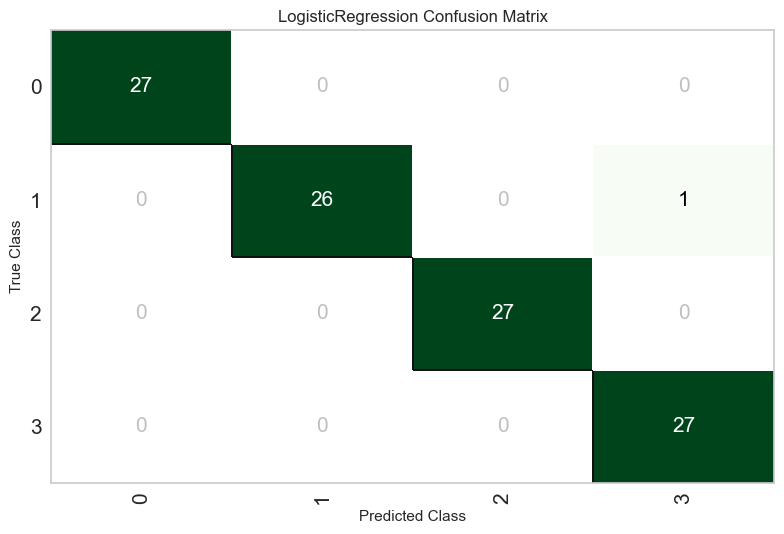

In [16]:
plot_model(best_model, plot='confusion_matrix')

In [17]:
evaluate_model(best_model)

interactive(children=(ToggleButtons(description='Plot Type:', icons=('',), options=(('Pipeline Plot', 'pipelin…

In [18]:
final_model = finalize_model(best_model)

2025/04/06 06:27:51 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


In [19]:
save_model(final_model, 'lr_task2_final')

Transformation Pipeline and Model Successfully Saved


(Pipeline(memory=Memory(location=None),
          steps=[('numerical_imputer',
                  TransformerWrapper(exclude=None,
                                     include=['feature_1', 'feature_2',
                                              'feature_3', 'feature_4',
                                              'feature_5', 'feature_6',
                                              'feature_7', 'feature_8',
                                              'feature_9', 'feature_10',
                                              'feature_11', 'feature_12',
                                              'feature_13', 'feature_14',
                                              'feature_15', 'feature_16',
                                              'feature_17', 'feature_18',
                                              'feature_19', 'feat...
                                                               fill_value=None,
                                                               k